In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn import model_selection
import torchvision.transforms as transforms
import torchvision.io 
import librosa
from PIL import Image
import albumentations as alb
import torch.multiprocessing as mp
import warnings

warnings.filterwarnings('ignore')

In [3]:
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping


In [4]:
!pip install -q torchtoolbox timm

In [5]:
class Config:
    use_aug = False
    num_classes = 264
    batch_size = 64
    epochs = 20
    PRECISION = 16    
    PATIENCE = 8    
    seed = 64
    model = "tf_efficientnet_b1_ns"
    pretrained = True            
    weight_decay = 1e-3
    use_mixup = True
    mixup_alpha = 0.6
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    

    data_root = "/kaggle/input/birdclef-2023/"
    train_images = "/kaggle/input/split-creating-melspecs-stage-1/specs/train/"
    valid_images = "/kaggle/input/split-creating-melspecs-stage-1/specs/valid/"
    train_path = "/kaggle/input/bc2023-train-val-df/train.csv"
    valid_path = "/kaggle/input/bc2023-train-val-df/valid.csv"
    
    
    SR = 32000
    DURATION = 5
    MAX_READ_SAMPLES = 5
    LR = 10e-4
    

In [6]:
pl.seed_everything(Config.seed, workers=True)

64

In [7]:
def config_to_dict(cfg):
    return dict((name, getattr(cfg, name)) for name in dir(cfg) if not name.startswith('__'))

In [8]:
df_train = pd.read_csv(Config.train_path)
df_valid = pd.read_csv(Config.valid_path)
df_train.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,len_sec_labels,path,frames,sr,duration
0,yebapa1,[],['song'],-3.3923,36.7049,Apalis flavida,Yellow-breasted Apalis,isaac kilusu,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/422175,yebapa1/XC422175.ogg,0,/kaggle/input/birdclef-2023/train_audio/yebapa...,405504,32000,12.672000
1,yebapa1,[],['song'],-0.6143,34.0906,Apalis flavida,Yellow-breasted Apalis,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/289562,yebapa1/XC289562.ogg,0,/kaggle/input/birdclef-2023/train_audio/yebapa...,796630,32000,24.894687
2,combuz1,[],['call'],51.8585,-8.2699,Buteo buteo,Common Buzzard,Irish Wildlife Sounds,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/626969,combuz1/XC626969.ogg,0,/kaggle/input/birdclef-2023/train_audio/combuz...,254112,32000,7.941000
3,chibat1,['laudov1'],"['adult', 'sex uncertain', 'song']",-33.1465,26.4001,Batis molitor,Chinspot Batis,Lynette Rudman,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/664196,chibat1/XC664196.ogg,1,/kaggle/input/birdclef-2023/train_audio/chibat...,1040704,32000,32.522000
4,carcha1,[],['song'],-34.0110,18.8078,Cossypha caffra,Cape Robin-Chat,Shannon Ronaldson,Creative Commons Attribution-NonCommercial-Sha...,1.0,https://www.xeno-canto.org/322333,carcha1/XC322333.ogg,0,/kaggle/input/birdclef-2023/train_audio/carcha...,40124,32000,1.253875


In [9]:
Config.num_classes = len(df_train.primary_label.unique())

In [10]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['primary_label'])], axis=1)
df_valid = pd.concat([df_valid, pd.get_dummies(df_valid['primary_label'])], axis=1)

## Create & Fill birds with 0 samples in validation

In [11]:
birds = list(df_train.primary_label.unique())

In [12]:
missing_birds = list(set(list(df_train.primary_label.unique())).difference(list(df_valid.primary_label.unique())))

In [13]:
non_missing_birds = list(set(list(df_train.primary_label.unique())).difference(missing_birds))

In [14]:
len(non_missing_birds)

254

In [15]:
df_valid[missing_birds] = 0
df_valid = df_valid[df_train.columns] ## Fix order

In [16]:
# df_train.iloc[:,17:]

In [17]:
import albumentations as A
from torchtoolbox.transform import Cutout
def get_train_transform():
    return A.Compose([
        Cutout()
    ])

In [18]:
class BirdDataset(torch.utils.data.Dataset):

    def __init__(self, df, sr = Config.SR, duration = Config.DURATION, augmentations = None, train = True):

        self.df = df
        self.sr = sr 
        self.train = train
        self.duration = duration
        self.augmentations = augmentations
        if train:
            self.img_dir = Config.train_images
        else:
            self.img_dir = Config.valid_images

    def __len__(self):
        return len(self.df)

    @staticmethod
    def normalize(image):
        image = image / 255.0
        #image = torch.stack([image, image, image])
        return image

    def __getitem__(self, idx):

        row = self.df.iloc[idx]
        impath = self.img_dir + f"{row.filename}.npy"

        image = np.load(str(impath))[:Config.MAX_READ_SAMPLES]
        
        ########## RANDOM SAMPLING ################
        if self.train:
            image = image[np.random.choice(len(image))]
        else:
            image = image[0]
            
        #####################################################################
        
        image = torch.tensor(image).float()

        if self.augmentations:
            image = self.augmentations(image.unsqueeze(0)).squeeze()
            
        image.size()
        
        image = torch.stack([image])

        image = self.normalize(image)


        return image, torch.tensor(row[17:]).float()


In [19]:
def get_fold_dls(df_train, df_valid, aug=None):

    ds_train = BirdDataset(
        df_train, 
        sr = Config.SR,
        duration = Config.DURATION,
        augmentations = aug,
        train = True
    )
    ds_val = BirdDataset(
        df_valid, 
        sr = Config.SR,
        duration = Config.DURATION,
        augmentations = None,
        train = False
    )
    dl_train = DataLoader(ds_train, batch_size=Config.batch_size , shuffle=True, num_workers = 0)    
    dl_val = DataLoader(ds_val, batch_size=Config.batch_size, num_workers = 0)
    return dl_train, dl_val, ds_train, ds_val

In [20]:
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(12, 6))    
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        img, lb = img_ds[img_index]        
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            img = img.transpose(1, 2, 0)
            ax.imshow(img)        
            
        title = f"Spec"
        ax.set_title(title)  

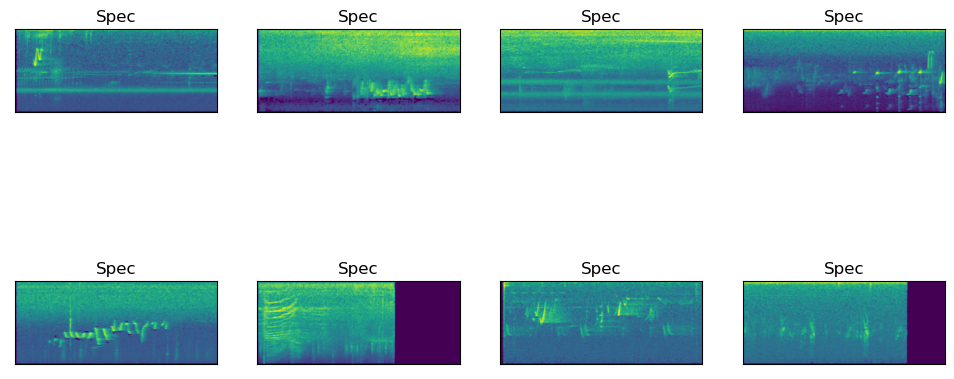

In [21]:
aug = get_train_transform()
dl_train, dl_val, ds_train, ds_val = get_fold_dls(df_train, df_valid)
show_batch(ds_val, 8, 2, 4)

In [22]:
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR

def get_optimizer(lr, params):
    model_optimizer = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, params), 
            lr=lr,
            weight_decay=Config.weight_decay
        )
    interval = "epoch"
    
    lr_scheduler = CosineAnnealingWarmRestarts(
                            model_optimizer, 
                            T_0=Config.epochs, 
                            T_mult=1, 
                            eta_min=1e-6, 
                            last_epoch=-1
                        )

    return {
        "optimizer": model_optimizer, 
        "lr_scheduler": {
            "scheduler": lr_scheduler,
            "interval": interval,
            "monitor": "val_loss",
            "frequency": 1
        }
    }

In [23]:
from torchtoolbox.tools import mixup_data, mixup_criterion
import torch.nn as nn
from torch.nn.functional import cross_entropy
import torchmetrics
import timm

In [24]:
import sklearn.metrics

def padded_cmap(solution, submission, padding_factor=5):
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

def map_score(solution, submission):
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    score = sklearn.metrics.average_precision_score(
        solution.values,
        submission.values,
        average='micro',
    )
    return score

In [25]:
dummy = df_valid[birds].copy()
dummy[birds] = np.random.rand(dummy.shape[0],dummy.shape[1])

In [26]:
padded_cmap(df_valid[birds], dummy[birds], padding_factor = 5)

0.47512409087815105

In [27]:
padded_cmap(df_valid[birds], dummy[birds], padding_factor = 1)

0.21321883340927572

In [28]:
map_score(df_valid[birds], dummy[birds])

0.0038613740463000782

In [29]:
class BirdClefModel(pl.LightningModule):
    def __init__(self, model_name=Config.model, num_classes = Config.num_classes, pretrained = Config.pretrained):
        super().__init__()
        self.num_classes = num_classes

        self.backbone = timm.create_model(model_name, pretrained=pretrained, in_chans=1)
        
#         self.train_losses = []
#         self.val_losses = []
        self.train_acc_history = []
        self.val_acc_history = []

        if 'res' in model_name:
            self.in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(self.in_features, num_classes)
        elif 'dense' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Linear(self.in_features, num_classes)
        elif 'efficientnet' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Sequential(
                nn.Linear(self.in_features, num_classes)
            )
        
        self.loss_function = nn.BCEWithLogitsLoss() 

    def forward(self,images):
        logits = self.backbone(images)
        return logits
        
    def configure_optimizers(self):
        return get_optimizer(lr=Config.LR, params=self.parameters())

    def train_with_mixup(self, X, y):
        X, y_a, y_b, lam = mixup_data(X, y, alpha=Config.mixup_alpha)
        y_pred = self(X)
        loss_mixup = mixup_criterion(cross_entropy, y_pred, y_a, y_b, lam)
        return loss_mixup

    def training_step(self, batch, batch_idx):
        image, target = batch    
        y_pred = self(image)

        if Config.use_mixup:
            loss = self.train_with_mixup(image, target)
        else:
            y_pred = self(image)
            loss = self.loss_function(y_pred,target)
        
#         self.train_losses.append(loss.item())
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        
        # Calculate training accuracy
        y_pred_class = (y_pred > 0.5).float()
        train_acc = (y_pred_class == target).float().mean()
        self.train_acc_history.append(train_acc.item())
        self.log("train_acc", train_acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss        

    def validation_step(self, batch, batch_idx):
        image, target = batch     
        y_pred = self(image)
        val_loss = self.loss_function(y_pred, target)
#         self.val_losses.append(val_loss.item())
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        
        # Calculate validation accuracy
        y_pred_class = (y_pred > 0.5).float()
        val_acc = (y_pred_class == target).float().mean()
        self.val_acc_history.append(val_acc.item())
        self.log("val_acc", val_acc, on_step=True, on_epoch=True, logger=True, prog_bar=True)

        return {"val_loss": val_loss, "logits": y_pred, "targets": target}
    
    def train_dataloader(self):
        return self._train_dataloader 
    
    def validation_dataloader(self):
        return self._validation_dataloader
    
  #     def plot_species_accuracy(self, true, pred):
#         species_acc = {}
#         for i, species in enumerate(birds):
#             species_acc[species] = (true[:, i] == pred[:, i]).mean()

#         plt.figure(figsize=(12, 8))
#         plt.bar(list(species_acc.keys()), list(species_acc.values()))
#         plt.xticks(rotation=90)
#         plt.xlabel('Species')
#         plt.ylabel('Accuracy')
#         plt.title('Accuracy per Species')
#         plt.savefig('species_accuracy.png')
#         plt.close()
    
        
    def validation_epoch_end(self,outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        output_val = torch.cat([x['logits'] for x in outputs],dim=0).sigmoid().cpu().detach().numpy()
        target_val = torch.cat([x['targets'] for x in outputs],dim=0).cpu().detach().numpy()
        
        # print(output_val.shape)
        val_df = pd.DataFrame(target_val, columns = birds)
        pred_df = pd.DataFrame(output_val, columns = birds)
        
        avg_score = padded_cmap(val_df, pred_df, padding_factor = 5)
        avg_score2 = padded_cmap(val_df, pred_df, padding_factor = 3)
        avg_score3 = sklearn.metrics.label_ranking_average_precision_score(target_val,output_val)
            
#         competition_metrics(output_val,target_val)
        print(f'epoch {self.current_epoch} validation loss {avg_loss}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 5 {avg_score}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 3 {avg_score2}')
        print(f'epoch {self.current_epoch} validation AP score {avg_score3}')
        
        
        val_df.to_pickle('val_df.pkl')
        pred_df.to_pickle('pred_df.pkl')
        
#         self.plot_species_accuracy(target_val, output_val)
#         self. plot_species_cmap(target_val, output_val)
#         self.plot_high_species_cmap(target_val, output_val)
    
        return {'val_loss': avg_loss,'val_cmap':avg_score}
    
    def on_train_end(self):
#         self.plot_train_loss()
#         self.plot_val_loss()
        self.plot_train_val_accuracy()
#         self.plot_loss_curves()

    def plot_train_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses[:20], label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()
        plt.savefig('train_loss_plot.png')
        plt.close()

    def plot_val_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.val_losses[:20], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Validation Loss')
        plt.legend()
        plt.savefig('val_loss_plot.png')
        plt.close()
        
        
    def plot_train_val_accuracy(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_acc_history[:20], label='Training Accuracy')
        plt.plot(self.val_acc_history[:20], label='Validation Accuracy')
        plt.xticks([0, 5, 10, 15, 20])
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.ylim(0, 1) 
        plt.legend()
        plt.savefig('accuracy_plot.png')
        plt.close()
    

    def plot_loss_curves(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses')
        plt.legend()
        plt.savefig('loss_plot.png')
        plt.close() 
        
    def plot_high_species_cmap(self, true, pred):
        species_cmap = {}
        val_df = pd.DataFrame(true, columns=birds)
        pred_df = pd.DataFrame(pred, columns=birds)

        for species in birds:
            cmap_score = padded_cmap(val_df[[species]], pred_df[[species]], padding_factor=5)
            if cmap_score > 0.8:
                species_cmap[species] = cmap_score

        if species_cmap:
            plt.figure(figsize=(12, 8))
            plt.bar(list(species_cmap.keys()), list(species_cmap.values()))
            plt.xticks(rotation=90)
            plt.xlabel('Species')
            plt.ylabel('cMAP')
            plt.title('cMAP per Species (cMAP > 0.8)')
            plt.savefig('species_cmap_gt_0.8.png')
            plt.close()
    
    def plot_species_cmap(self, true, pred):
        species_cmap = {}
        val_df = pd.DataFrame(true, columns=birds)
        pred_df = pd.DataFrame(pred, columns=birds)

        for species in birds:
            species_cmap[species] = padded_cmap(val_df[[species]], pred_df[[species]], padding_factor=5)

        plt.figure(figsize=(12, 8))
        plt.bar(list(species_cmap.keys()), list(species_cmap.values()))
        plt.xticks(rotation=90)
        plt.xlabel('Species')
        plt.ylabel('cMAP')
        plt.title('cMAP per Species')
        plt.savefig('species_cmap.png')
        plt.close()

In [30]:
from pytorch_lightning.loggers import WandbLogger
import gc

def run_training():
    print(f"Running training...")
    logger = None
    
    
    dl_train, dl_val, ds_train, ds_val = get_fold_dls(df_train, df_valid)
    
    audio_model = BirdClefModel()

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=Config.PATIENCE, verbose= True, mode="min")
    checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                          dirpath= "/kaggle/working/exp1/",
                                      save_top_k=1,
                                      save_last= True,
                                      save_weights_only=True,
                                      filename= f'./{Config.model}_loss',
                                      verbose= True,
                                      mode='min')
    
    callbacks_to_use = [checkpoint_callback,early_stop_callback]


    trainer = pl.Trainer(
        gpus=1,
        val_check_interval=0.5,
        deterministic=True,
        max_epochs=Config.epochs,
        logger=logger,
        auto_lr_find=False,    
        callbacks=callbacks_to_use,
        precision=Config.PRECISION, accelerator="gpu" 
    )

    print("Running trainer.fit")
    trainer.fit(audio_model, train_dataloaders = dl_train, val_dataloaders = dl_val)                

    gc.collect()
    torch.cuda.empty_cache()


In [31]:
run_training()

Running training...


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b1_ns-99dd0c41.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b1_ns-99dd0c41.pth


Running trainer.fit


Sanity Checking: 0it [00:00, ?it/s]

epoch 0 validation loss 0.7005054950714111
epoch 0 validation C-MAP score pad 5 0.9416817748869332
epoch 0 validation C-MAP score pad 3 0.9136201852897469
epoch 0 validation AP score 0.017937924896544166


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch 0 validation loss 0.29972636699676514
epoch 0 validation C-MAP score pad 5 0.5892282936478579
epoch 0 validation C-MAP score pad 3 0.4971605461302778
epoch 0 validation AP score 0.4546499864850866


Validation: 0it [00:00, ?it/s]

epoch 0 validation loss 0.2400784194469452
epoch 0 validation C-MAP score pad 5 0.670390825469153
epoch 0 validation C-MAP score pad 3 0.5884185977776544
epoch 0 validation AP score 0.5795207051301625


Validation: 0it [00:00, ?it/s]

epoch 1 validation loss 0.24786677956581116
epoch 1 validation C-MAP score pad 5 0.7126222469402628
epoch 1 validation C-MAP score pad 3 0.6384752067270977
epoch 1 validation AP score 0.6349847616008191


Validation: 0it [00:00, ?it/s]

epoch 1 validation loss 0.2269856482744217
epoch 1 validation C-MAP score pad 5 0.7408706334346331
epoch 1 validation C-MAP score pad 3 0.6723757621777073
epoch 1 validation AP score 0.6760587388112925


Validation: 0it [00:00, ?it/s]

epoch 2 validation loss 0.21440228819847107
epoch 2 validation C-MAP score pad 5 0.7496260108444435
epoch 2 validation C-MAP score pad 3 0.6815309909916132
epoch 2 validation AP score 0.7002192209775445


Validation: 0it [00:00, ?it/s]

epoch 2 validation loss 0.20856046676635742
epoch 2 validation C-MAP score pad 5 0.7759912289373613
epoch 2 validation C-MAP score pad 3 0.7135651862124417
epoch 2 validation AP score 0.7315481734430843


Validation: 0it [00:00, ?it/s]

epoch 3 validation loss 0.17558102309703827
epoch 3 validation C-MAP score pad 5 0.7798614473038311
epoch 3 validation C-MAP score pad 3 0.7190705838300671
epoch 3 validation AP score 0.7276329736514396


Validation: 0it [00:00, ?it/s]

epoch 3 validation loss 0.18635490536689758
epoch 3 validation C-MAP score pad 5 0.7874467659088086
epoch 3 validation C-MAP score pad 3 0.7283500788000978
epoch 3 validation AP score 0.7390292092916476


Validation: 0it [00:00, ?it/s]

epoch 4 validation loss 0.15977166593074799
epoch 4 validation C-MAP score pad 5 0.7957421113278129
epoch 4 validation C-MAP score pad 3 0.7378765406010956
epoch 4 validation AP score 0.7551667754287981


Validation: 0it [00:00, ?it/s]

epoch 4 validation loss 0.1511235535144806
epoch 4 validation C-MAP score pad 5 0.7966793815338138
epoch 4 validation C-MAP score pad 3 0.7397418180253333
epoch 4 validation AP score 0.7535670462492837


Validation: 0it [00:00, ?it/s]

epoch 5 validation loss 0.16350364685058594
epoch 5 validation C-MAP score pad 5 0.8083536367086203
epoch 5 validation C-MAP score pad 3 0.7542438313416782
epoch 5 validation AP score 0.7703797878043216


Validation: 0it [00:00, ?it/s]

epoch 5 validation loss 0.1517932415008545
epoch 5 validation C-MAP score pad 5 0.8153279971652125
epoch 5 validation C-MAP score pad 3 0.7629043845542494
epoch 5 validation AP score 0.7705204042267796


Validation: 0it [00:00, ?it/s]

epoch 6 validation loss 0.1424005776643753
epoch 6 validation C-MAP score pad 5 0.8138805926749073
epoch 6 validation C-MAP score pad 3 0.7614223910120725
epoch 6 validation AP score 0.7791055635347303


Validation: 0it [00:00, ?it/s]

epoch 6 validation loss 0.13638406991958618
epoch 6 validation C-MAP score pad 5 0.8093143238945473
epoch 6 validation C-MAP score pad 3 0.7562529776560123
epoch 6 validation AP score 0.7746269929150762


Validation: 0it [00:00, ?it/s]

epoch 7 validation loss 0.13719134032726288
epoch 7 validation C-MAP score pad 5 0.8214726863013165
epoch 7 validation C-MAP score pad 3 0.7708304712482493
epoch 7 validation AP score 0.7894855001935467


Validation: 0it [00:00, ?it/s]

epoch 7 validation loss 0.13511614501476288
epoch 7 validation C-MAP score pad 5 0.8200289439394329
epoch 7 validation C-MAP score pad 3 0.7694291292259334
epoch 7 validation AP score 0.7878335548107613


Validation: 0it [00:00, ?it/s]

epoch 8 validation loss 0.13298892974853516
epoch 8 validation C-MAP score pad 5 0.8262140363548321
epoch 8 validation C-MAP score pad 3 0.7768242504591532
epoch 8 validation AP score 0.7980242445385539


Validation: 0it [00:00, ?it/s]

epoch 8 validation loss 0.12628115713596344
epoch 8 validation C-MAP score pad 5 0.8272835565289508
epoch 8 validation C-MAP score pad 3 0.7785407991430963
epoch 8 validation AP score 0.7919737007135611


Validation: 0it [00:00, ?it/s]

epoch 9 validation loss 0.12544633448123932
epoch 9 validation C-MAP score pad 5 0.8315069074754694
epoch 9 validation C-MAP score pad 3 0.7823201889789098
epoch 9 validation AP score 0.8053508197252839


Validation: 0it [00:00, ?it/s]

epoch 9 validation loss 0.12437792122364044
epoch 9 validation C-MAP score pad 5 0.8323275728408615
epoch 9 validation C-MAP score pad 3 0.7845390675006324
epoch 9 validation AP score 0.8008844961647293


Validation: 0it [00:00, ?it/s]

epoch 10 validation loss 0.12465216219425201
epoch 10 validation C-MAP score pad 5 0.8380995128979136
epoch 10 validation C-MAP score pad 3 0.7917300320904961
epoch 10 validation AP score 0.8153531991978531


Validation: 0it [00:00, ?it/s]

epoch 10 validation loss 0.12561455368995667
epoch 10 validation C-MAP score pad 5 0.8368841261639967
epoch 10 validation C-MAP score pad 3 0.789645376446027
epoch 10 validation AP score 0.8151198269997032


Validation: 0it [00:00, ?it/s]

epoch 11 validation loss 0.12251418828964233
epoch 11 validation C-MAP score pad 5 0.8382607755409028
epoch 11 validation C-MAP score pad 3 0.7920336779898529
epoch 11 validation AP score 0.8121169003287931


Validation: 0it [00:00, ?it/s]

epoch 11 validation loss 0.1304551661014557
epoch 11 validation C-MAP score pad 5 0.8384705636801874
epoch 11 validation C-MAP score pad 3 0.7923148367973083
epoch 11 validation AP score 0.8190015346473419


Validation: 0it [00:00, ?it/s]

epoch 12 validation loss 0.11314745247364044
epoch 12 validation C-MAP score pad 5 0.8408496798515835
epoch 12 validation C-MAP score pad 3 0.7949170871800046
epoch 12 validation AP score 0.8209791211085344


Validation: 0it [00:00, ?it/s]

epoch 12 validation loss 0.1152191162109375
epoch 12 validation C-MAP score pad 5 0.8389530080898049
epoch 12 validation C-MAP score pad 3 0.7929754749942649
epoch 12 validation AP score 0.8200624728742987


Validation: 0it [00:00, ?it/s]

epoch 13 validation loss 0.11573918163776398
epoch 13 validation C-MAP score pad 5 0.8392921977322136
epoch 13 validation C-MAP score pad 3 0.7937407109213488
epoch 13 validation AP score 0.8178047591864245


Validation: 0it [00:00, ?it/s]

epoch 13 validation loss 0.11466839909553528
epoch 13 validation C-MAP score pad 5 0.8432680080832704
epoch 13 validation C-MAP score pad 3 0.7983451942926436
epoch 13 validation AP score 0.822793934823913


Validation: 0it [00:00, ?it/s]

epoch 14 validation loss 0.11315066367387772
epoch 14 validation C-MAP score pad 5 0.8408866052749971
epoch 14 validation C-MAP score pad 3 0.7952452243011464
epoch 14 validation AP score 0.8253511286654953


Validation: 0it [00:00, ?it/s]

epoch 14 validation loss 0.11661085486412048
epoch 14 validation C-MAP score pad 5 0.8399743196078517
epoch 14 validation C-MAP score pad 3 0.7943924682778056
epoch 14 validation AP score 0.825196760159154


Validation: 0it [00:00, ?it/s]

epoch 15 validation loss 0.11745013296604156
epoch 15 validation C-MAP score pad 5 0.842207574074747
epoch 15 validation C-MAP score pad 3 0.7973197442629028
epoch 15 validation AP score 0.826189135872884


Validation: 0it [00:00, ?it/s]

epoch 15 validation loss 0.11175934970378876
epoch 15 validation C-MAP score pad 5 0.8438597462070796
epoch 15 validation C-MAP score pad 3 0.7993536202871077
epoch 15 validation AP score 0.828685966534702


Validation: 0it [00:00, ?it/s]

epoch 16 validation loss 0.11071855574846268
epoch 16 validation C-MAP score pad 5 0.8428376205774019
epoch 16 validation C-MAP score pad 3 0.7980159760208648
epoch 16 validation AP score 0.827582617283321


Validation: 0it [00:00, ?it/s]

epoch 16 validation loss 0.11824368685483932
epoch 16 validation C-MAP score pad 5 0.8404057452714081
epoch 16 validation C-MAP score pad 3 0.7951042812976999
epoch 16 validation AP score 0.8241173665249723


Validation: 0it [00:00, ?it/s]

epoch 17 validation loss 0.11353951692581177
epoch 17 validation C-MAP score pad 5 0.8418133046977684
epoch 17 validation C-MAP score pad 3 0.7968414726413564
epoch 17 validation AP score 0.8284054837426272


Validation: 0it [00:00, ?it/s]

epoch 17 validation loss 0.11052105575799942
epoch 17 validation C-MAP score pad 5 0.843073667673908
epoch 17 validation C-MAP score pad 3 0.7985461810168565
epoch 17 validation AP score 0.8277332371665864


Validation: 0it [00:00, ?it/s]

epoch 18 validation loss 0.10637377202510834
epoch 18 validation C-MAP score pad 5 0.8440165861655673
epoch 18 validation C-MAP score pad 3 0.7996059350507759
epoch 18 validation AP score 0.8297302848987649


Validation: 0it [00:00, ?it/s]

epoch 18 validation loss 0.11434891819953918
epoch 18 validation C-MAP score pad 5 0.843103443801107
epoch 18 validation C-MAP score pad 3 0.798413451439939
epoch 18 validation AP score 0.8263639415490853


Validation: 0it [00:00, ?it/s]

epoch 19 validation loss 0.10277890413999557
epoch 19 validation C-MAP score pad 5 0.843452434236096
epoch 19 validation C-MAP score pad 3 0.798989647389696
epoch 19 validation AP score 0.8284469847028032


Validation: 0it [00:00, ?it/s]

epoch 19 validation loss 0.11251100897789001
epoch 19 validation C-MAP score pad 5 0.8424291612484556
epoch 19 validation C-MAP score pad 3 0.7975772247816415
epoch 19 validation AP score 0.828155709406779


In [33]:
pred = pd.read_pickle('/kaggle/working/pred_df.pkl')
true = pd.read_pickle('/kaggle/working/val_df.pkl')

In [34]:
true.sum(axis=1)

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
3382    1.0
3383    1.0
3384    1.0
3385    1.0
3386    1.0
Length: 3387, dtype: float32

In [35]:
pred.sum(axis=1)

0       49.718750
1       14.070312
2       21.671875
3       13.226562
4       11.703125
          ...    
3382    24.406250
3383    30.328125
3384     4.656250
3385    21.453125
3386    21.390625
Length: 3387, dtype: float16

In [36]:
padded_cmap(true, pred, padding_factor = 5)

0.8424291612484556

In [37]:
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true, pred, labels):
    # Check the shapes of true and pred
    print(f"true shape: {true.shape}")
    print(f"pred shape: {pred.shape}")
    print(f"labels length: {len(labels)}")

    # Convert true and pred to the same format
    if true.shape[1] == len(labels):
        true_labels = true.idxmax(axis=1)
    else:
        true_labels = np.argmax(true.values, axis=1)

    if pred.shape[1] == len(labels):
        pred_labels = pred.idxmax(axis=1)
    else:
        pred_labels = np.argmax(pred.values, axis=1)

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    # Plot the confusion matrix
    fig = go.Figure(data=go.Heatmap(
        z=cm_normalized,
        x=labels,
        y=labels,
        colorscale='RdBu'
    ))

    fig.update_layout(
        title='Confusion Matrix',
        xaxis_title='Predicted Label',
        yaxis_title='True Label',
        width=800,
        height=800
    )

    fig.show()


plot_confusion_matrix(true, pred, birds)

true shape: (3387, 264)
pred shape: (3387, 264)
labels length: 264
